## 작사가 만들기

###  #이론

#### 1. 시퀀스
- 시퀀스의 데이터는 어떤 기준에 따라 정렬되었을 수도 있고 무작위로 나열되었을 수도 있다.
- 우리(인공지능)가 예측을 하려면 어느 정도는 연관성이 있어줘야 함
- 문장을 구성하는 각 단어들은 문법이라는 규칙을 따라 배열
- 문장 데이터는 통계에 기반한 방법으로 데이터 예측

#### 2. 인공지능이 글을 이해하게 하는 방식
- 수 많은 글을 릭게 함 -> '나는' '밥을' 그다음이 '먹는다' 라는 사실을 알게함
- 많은 데이터가 좋은 결과를 가져옴
- 순환신경망(RNN) 인공지능 이용
    - 생성한 단어를 다시 입력으로 사용
    - 'start' 라는 특수토큰을 맨앞에 추가하여 문장을 생성하라는 사인을 줌 => 입력
    -  사인을 받은 후 '나는' 이라는 단어를 만든다  => 출력 
    -  만들어진 '나는'으로 새로운 단어를 만듬 => '나는'이 입력값
    - '나는 밥을 먹었다' 라는 생성을 끝내면 'end 가 나옴
    
    
#### 3. 언어모델
- 어떤 문구 뒤에 다음 단어가 나올 확률은 이미 만들어진 글이 많을수록 확률이 높고,
- 확률이 높다는 것은 그 단어가 자연스럽다는 것, 
- n−1개의 단어 시퀀스가 있을 때 n 번째 단어로 무엇이 올지 예측하는 확률모델
- 학습시키는 방법 -> 어떤 텍스트도 가능, n-1 번째 까지 단어 시퀀스가X_train, n 번째 단어는 y_train이 되는 데이터 셋은 무한으로 만들수있다. 
- 잘 학습된 언어 모델은 훌륭한 문장 생성기로 동작 (ex:  GPT-2 같은 문장 생성기)

## #실습

### <1> 데이터 다듬기

#### 1. 데이터 다운로드
```
$ mkdir -p ~/aiffel/lyricist/models
$ ln -s ~/data ~/aiffel/lyricist/data
```

#### 2. 라이브러리 불러와서 파일 내용 확인

In [1]:
import os, re 
import numpy as np
import tensorflow as tf

# 파일을 읽기모드로 열고
# 준비한 파일의 내용을 확인
# 라인 단위로 끊어서 list 형태로 읽어옵니다.
file_path = os.getenv('HOME') + '/aiffel/lyricist/data/shakespeare.txt'
with open(file_path, "r") as f:
    raw_corpus = f.read().splitlines()

# 앞에서부터 10라인만 화면에 출력해 볼까요?
print(raw_corpus[:9])

['First Citizen:', 'Before we proceed any further, hear me speak.', '', 'All:', 'Speak, speak.', '', 'First Citizen:', 'You are all resolved rather to die than to famish?', '']


---
#### 3. 필요한 파일만 가져오도록 필터링

3-1. .splitlines()  :문자열을 목록으로 분할, 분할은 줄 바꿈에서 수행
3-2. 경로를 따라 데이터를 읽어오면 데이터가 어떻게 생겼는지 눈으로 확인
 나에게 필요한 데이터는 문장(대사) 만이므로 화자이름이나 공백정보는 필요가 없음
3-3. 데이터형태를 살피며 필터를 구상해봄
  - 모든 문장을 하나씩 검사 -> for 사용
  - enumerate() 함수
     - 기본적으로 인덱스와 원소로 이루어진 터플(tuple)을 만들
     - 인덱스(index)와 원소를 동시에 접근
     - for 문의 in 뒷 부분을 enumerate() 함수로 한 번 감싸
     
3-4. 필요없는 문장이 가지고 있는 데이터의 특성을 코드로 만든다. 
   - 화자가 표기된 문장은 문장의 끝이 : 으로 끝나게 되어있어서 :를 기준으로 문장을 제외
   - 공백인 문장은 길이를 검사하여 길이가 0이라면 제외

In [17]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.
   

    if idx > 20: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(idx, sentence) # idx는 인덱스 값도 같이 보여지게함.

0 At first I was afraid
1 I was petrified
2 I kept thinking I could never live without you
3 By my side But then I spent so many nights
4 Just thinking how you've done me wrong
5 I grew strong
6 I learned how to get along And so you're back
7 From outer space
8 I just walked in to find you
9 Here without that look upon your face I should have changed that fucking lock
10 I would have made you leave your key
11 If I had known for just one second
12 You'd be back to bother me Well now go,
13 Walk out the door
14 Just turn around
15 Now, you're not welcome anymore Weren't you the one
16 Who tried to break me with desire?
17 Did you think I'd crumble?
18 Did you think I'd lay down and die? Oh not I,
19 I will survive
20 Yeah


---
3-5. **토큰화(Tokenize) : 문장을 일정한 기준으로 쪼개는 과정**
텍스트 분류 모델에서 많이 보신 것처럼 텍스트 생성 모델에도 단어 사전을 만들게 되면서 문장을 일정한 기준으로 쪼개야 한다. 이 과정을 토큰화 라고 함.  가장 심플한 방법은 '띄어쓰기', 문장부호포함, 대소문자 구별못함, 특수문자로 이어진 글을 한단어로인식 등에 대해 문제가 생길수있다.

- 문장부호 포함 방지 : 문장부호 양쪽에 공백추가
- 대소문자 구별못해 다른단어로 인식 방지 : 모든 문자들을 소문자로 변환
- 특수문자로 이어진 글을 한단어로 인식 방지: 특수문자 제거

3.6 위와 같은 전처리를 위한 정규표현식(Regex)을 이용한 필터링 사용

In [3]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


---
#### 4. 데이터셋 (정제 데이터 구축, 데이터 전처리)
- 자연어 처리 분야에서 관례적으로 부르는 것 

  - 모델의 입력이 되는 문장:  소스 문장(Source Sentence)              ->  X_train
  - 정답 역할을 하게 될 모델의 출력 문장 : 타겟 문장(Target Sentence) ->  y_train
  
- 정제 함수를 통해 만든 데이터셋에서 토큰화를 진행한 후 끝 단어 `<end>`를 없애면 소스 문장
- 첫 단어 `<start>`를 없애면 타겟 문장

In [4]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> before we proceed any further , hear me speak . <end>',
 '<start> speak , speak . <end>',
 '<start> you are all resolved rather to die than to famish ? <end>',
 '<start> resolved . resolved . <end>',
 '<start> first , you know caius marcius is chief enemy to the people . <end>',
 '<start> we know t , we know t . <end>',
 '<start> let us kill him , and we ll have corn at our own price . <end>',
 '<start> is t a verdict ? <end>',
 '<start> no more talking on t let it be done away , away ! <end>',
 '<start> one word , good citizens . <end>']

---
- 인공지능의 모국어는 숫자 . 가르칠 언어(데이터)를 숫자로 변환해서 인공지능에게 준다.

- 텐서플로우 tf.keras.preprocessing.text.Tokenizer 패키지
    - 벡터화(vectorize) : 정제된 데이터를 토큰화하고, 단어 사전(vocabulary 또는 dictionary라고 칭함)을 만들어주며, 데이터를 숫자로 변환 과정
    - **텐서(tensor) : 숫자로 변환된 데이터**
    - 우리가 사용하는 텐서플로우로 만든 모델의 입출력 데이터는 실제로는 모두 이런 텐서로 변환되어 처리되는 것

In [5]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2  143   40 ...    0    0    0]
 [   2  110    4 ...    0    0    0]
 [   2   11   50 ...    0    0    0]
 ...
 [   2  149 4553 ...    0    0    0]
 [   2   34   71 ...    0    0    0]
 [   2  945   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f3b0677ae90>


In [6]:
# 생성된 데이터를 3번째 행 10번째 열가지만 출력
# 2로 시작되는 행 : 사전을 통해 start 임을 확인

print(tensor[:3, :10])

[[   2  143   40  933  140  591    4  124   24  110]
 [   2  110    4  110    5    3    0    0    0    0]
 [   2   11   50   43 1201  316    9  201   74    9]]


In [7]:
# 위 정수는 tokenizer에 구축된 단어 사전의 인덱스
# 단어 사전 확인 코드

for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx]) #idx 인덱스번호, ":" 프린트시 보이는 str
    
    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : .
6 : the
7 : and
8 : i
9 : to
10 : of


---
#### 5. 모델이 학습할수 있도록 생성된 텐서를 소스( X-train)와 타겟(y_train)으로 분리
- 텐서 출력부에서 행 뒤쪽에 0이 많이 나온 부분은 정해진 입력 시퀀스 길이보다 문장이 짧을 경우 0으로 패딩(padding)을 채워 넣은 것. 사전에는 없지만 인덱스 0은 바로 패딩 문자 `<pad>`가 될 것
- 텐서는 일종의 np.arrays와 같음

In [8]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.

src_input = tensor[:, :-1]  # 인덱스 -1인 끝까지 보여줌

# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다. 인덱스 1부터 보여줌

tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

# corpus 내의 첫 번째 문장에 대해 생성된 소스와 타겟 문장을 확인해 보았습니다. 
# 예상대로 소스는 2(<start>)에서 시작해서 3(<end>)으로 끝난 후 0(<pad>)로 채워져 
# 있습니다. 하지만 타겟은 2로 시작하지 않고 소스를 왼쪽으로 한 칸 시프트 한 형태

[  2 143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0
   0   0]
[143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0   0
   0   0]


 #### 6. 데이터셋 객체 생성
 - 이전 학습법 : model.fit(x_train, y_train, ...) 형태로 Numpy Array 데이터셋을 생성하여 model에 제공하는 형태의 학습
 -  텐서플로우를 활용할 경우 텐서로 생성된 데이터를 이용해 tf.data.Dataset객체를 생성하는 방법을 흔히 사용
 - tf.data.Dataset객체는 텐서플로우에서 사용할 경우 데이터 입력 파이프라인을 통한 속도 개선 및 각종 편의 기능을 제공
 -  이미 데이터셋을 텐서 형태로 생성해 두었으므로, tf.data.Dataset.from_tensor_slices() 메소드를 이용해 tf.data.Dataset객체를 생성
 
 
- 아래 코드 설명
  - tf.data.Dataset.from_tensor_slices :  데이터 셋트를 변환을 적용
  - shuffle() 
    - 데이터 셋트의 요소를 무작위로 섞음,  
    - 데이터세트는 버퍼를 buffer_size요소로 채운 다음 이 버퍼에서 무작위로 요소를 샘플링하여 선택한 요소를 새 요소로 바꿉니다. 
    -  완벽한 셔플링을 위해서는 데이터 세트의 전체 크기보다 크거나 같은 버퍼 크기가 필요
    - BUFFER_SIZE 는 src_input 데이터의 크기와 같게 설정해놓음
    
  - batch(BATCH_SIZE, drop_remainder=True)
    -  위에서 선언된 dataset 을  BATCH_SIZE 만큼씩 나누고, 
    -  drop_remainder=True 는 나눈 후 갯수를  채우지않는 array 를 없앰

In [9]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))

dataset = dataset.shuffle(BUFFER_SIZE)

dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)


dataset

<BatchDataset shapes: ((256, 20), (256, 20)), types: (tf.int32, tf.int32)>

---
### <2> 인공지능 학습시키기
#### 1. - 모델 구조도
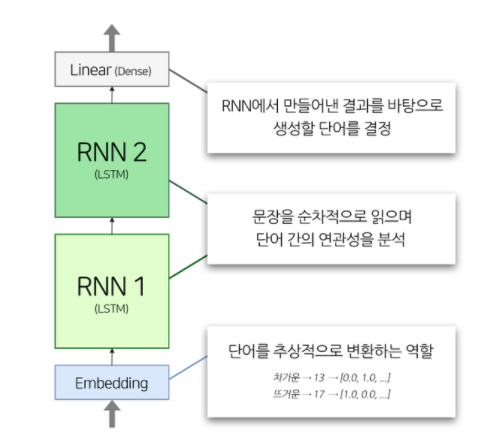

- tf.keras.Model을 Subclassing하는 방식

#### 2. 각 코드 및 모델 상세설명
-  Embedding 레이어
   - 우리 입력 텐서에는 단어 사전의 인덱스가 들어 있습니다. Embedding 레이어는 이 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔줌
   - 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현(representation)으로 사용
   - `embedding_size` 는 워드 벡터의 차원수, 즉 단어가 추상적으로 표현되는 크기, 값이 커질수록 추상적인 특징들을 잡아낼수있지만 그만큼 충분한 데이터가 주어지지않으면 오이혀 혼란하게 됨, 그래서 실습시 256
   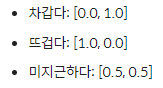
   - `hidden_size`는  LSTM  레이어의 hidden state 의 차원수, 모델에 얼마나 많은 일꾼을 둘것인가정도의 의미, 일꾼들은 모두 같은 데이터를 보고 각자의 생각을 가지느데, 충분한 데이터가 없으면 각자의 생각이 많아져서 배가 산으로 감. 그래서 실습시 1024

In [10]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

- model은 아직 제대로 build되지 않은상태 
  - model.compile()을 호출한 적도 없고, 
  - 아직 model의 입력 텐서가 무엇인지 제대로 지정해 주지도 않았기 때문
  - 그런 경우 아래와 같이 model에 데이터를 아주 조금 태워 보는 것도 방법입니다. 
  -  model의 input shape가 결정되면서 model.build()가 자동으로 호출됨

In [11]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 20, 7001), dtype=float32, numpy=
array([[[ 1.38565709e-04, -5.69218500e-05,  2.92288692e-04, ...,
         -5.40002948e-04, -1.79920389e-04,  3.56970966e-04],
        [ 6.11197611e-05, -1.05108564e-04,  3.40956583e-04, ...,
         -7.51114741e-04,  1.19887671e-04,  9.68080480e-04],
        [-9.36810829e-05, -2.85476155e-04,  2.75095197e-04, ...,
         -9.16170480e-04,  1.32355912e-04,  1.36876095e-03],
        ...,
        [ 6.29092334e-04, -5.06457582e-04, -1.39031466e-03, ...,
         -2.22158385e-03, -1.64480938e-03,  2.10607162e-04],
        [ 8.29570228e-04, -7.83429481e-04, -1.55770278e-03, ...,
         -2.59099668e-03, -1.81135803e-03,  6.73497270e-05],
        [ 9.81268240e-04, -1.06265605e-03, -1.69775402e-03, ...,
         -2.90435227e-03, -1.93757820e-03, -3.76480566e-05]],

       [[ 1.38565709e-04, -5.69218500e-05,  2.92288692e-04, ...,
         -5.40002948e-04, -1.79920389e-04,  3.56970966e-04],
        [ 1.63910750e-04,  1.38969917e-04,  8.

모델의 최종 출력 텐서 shape=(256, 20, 7001)
-  7001은 Dense 레이어의 출력 차원수
-  7001개의 단어 중 어느 단어의 확률이 가장 높을지를 모델링
-  256은 이전 스텝에서 지정한 배치 사이즈
-  dataset.take(1)를 통해서 1개의 배치, 즉 256개의 문장 데이터를 가져온 것
-  20은   ``` self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
     self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)``` 
     return_sequences=True이라고 지정한 부분때문이다. LSTM은 자신에게 입력된 시퀀스의 길이만큼 동일한 길이의 시퀀스를 출력함. 만약 False dlaus LSTM 레이어는 1개의 벡터만 출력했을 것
- 하지만 우리는 입력 데이터의 시퀀스 길이가 얼마인지 모른다. 모델을 만들며 알려준적도 없다. 데이터를 입력받으면서 알게된것. -> 데이터 셋의 max)len이 20으로 맞춰져있었음
   - ```model.summary()``` 호출이 가능하고, 확인가능해짐

In [12]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1792256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  7176025   
Total params: 22,607,961
Trainable params: 22,607,961
Non-trainable params: 0
_________________________________________________________________


- 호출해 보니 그동안 많이 보았던 것과는 다른 점이 있습니다. 
- 우리가 궁금했던 Output Shape를 정확하게 알려주지 않습니다. 바로 위에서 설명한 이유 때문입니다. 우리의 모델은 입력 시퀀스의 길이를 모르기 때문에 Output Shape를 특정할 수 없는 것입니다.
- 하지만 모델의 파라미터 사이즈는 측정(Total params)됩니다. 대략 22million 정도 


#### 3. 위코드까지 모델이 학습할 준비 완료!!! 
####    이제 모델을 학습시키기
- Loss는 모델이 오답을 만들고 있는 정도
- 오답률이 감소하고 있으니 학습이 잘 진행되고 있다 고 해석하면됨

In [14]:
# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다


optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, epochs=30)

Epoch 1/30
93/93 [==============================] - 71s 742ms/step - loss: 2.8654
Epoch 2/30
11/93 [==>...........................] - ETA: 1:00 - loss: 2.6510

KeyboardInterrupt: 

### <3> 인공지능 모델 평가
-  작문을 시켜보고 직접 평가
- generate_text 함수는 모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행

In [ ]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

generate_text() 함수에서 init_sentence를 인자로 받고는 있습니다. 이렇게 받은 인자를 일단 텐서로 만들고 있습니다. 디폴트로는 `<start>` 단어 하나만 받는군요.
    
-  while의 첫 번째 루프에서 test_tensor에 `<start>` 하나만 들어갔다고 합시다. 우리의 모델이 출력으로 7001개의 단어 중 A를 골랐다고 합시다.
-  while의 두 번째 루프에서 test_tensor에는 `<start> A`가 들어갑니다. 그래서 우리의 모델이 그다음 B를 골랐다고 합시다.
- while의 세 번째 루프에서 test_tensor에는 `<start> A B`가 들어갑니다. 그래서..... (이하 후략)

In [ ]:
# 문장 생성 함수 실행
#init_sentence 를 바꿔가며 이런저런 실험

generate_text(model, tokenizer, init_sentence="<start> i")

## ✔프로젝트: 멋진 작사가 만들기
### step1. 데이터 다운로드 : 이미 데이터 있음
- Cloud shell에 심볼릭 링크로 ~/aiffel/lyricist/data를 생성, ~/aiffel/lyricist/data/lyrics에 데이터가 있음

### step2. 데이터 읽어오기
- glob 모듈을 사용하면 파일을 읽어오는 작업을 하기가 아주 용이
- glob 를 활용하여 모든 txt 파일을 읽어온 후, 
- raw_corpus 리스트에 문장 단위로 저장

In [3]:
import glob
import os
import os, re 
import numpy as np
import tensorflow as tf

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:20]) #샘플문장확인 19 인덱스까지

데이터 크기: 187088
Examples:
 ['At first I was afraid', 'I was petrified', 'I kept thinking I could never live without you', 'By my side But then I spent so many nights', "Just thinking how you've done me wrong", 'I grew strong', "I learned how to get along And so you're back", 'From outer space', 'I just walked in to find you', 'Here without that look upon your face I should have changed that fucking lock', 'I would have made you leave your key', 'If I had known for just one second', "You'd be back to bother me Well now go,", 'Walk out the door', 'Just turn around', "Now, you're not welcome anymore Weren't you the one", 'Who tried to break me with desire?', "Did you think I'd crumble?", "Did you think I'd lay down and die? Oh not I,", 'I will survive']


### step3. 데이터 정제
- preprocess_sentence() 함수 활용해 데이터를 정제
- 지나치게 긴 문장은 다른 데이터들이 과도하게 패딩을 갖게하므로 15개 이하 문장 제외하는 코드 만들기
#### 1.  필요한 파일만 가져오도록 필터링 (정제하는 방법찾는것)

- 빈셀은 없으므로 넘어가고, 쉼표 같은 특수문자가 있어서 없애기
- sentence 문장안의 단어 갯수 15개 이상이면 넘어가기 
- for 문을 돌리고 확인해보면서 내가 원하는 데이터만 가져오는지 확인하기


In [4]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.
    if idx > 10: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(idx, sentence)

0 At first I was afraid
1 I was petrified
2 I kept thinking I could never live without you
3 By my side But then I spent so many nights
4 Just thinking how you've done me wrong
5 I grew strong
6 I learned how to get along And so you're back
7 From outer space
8 I just walked in to find you
9 Here without that look upon your face I should have changed that fucking lock
10 I would have made you leave your key


In [5]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 소문자변경, 양쪽공백지우기
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 특수문자 양쪽에 공백넣기
    sentence = re.sub(r'[" "]+', " ", sentence) # 여러개공백은 하나로 바꾸기
    sentence = re.sub(r"[^a-zA-Z?.!¿]+", " ", sentence) # ^a-zA-Z?.!,¿ 가 아닌 모든 문자를 하나의 공백으로 바꿈
    sentence = sentence.strip() # 다시 양쪽 공백 지움
    sentence = '<start> ' + sentence + ' <end>' # dkvdp <start>, 끝에<end> 입력
    return sentence

In [6]:
# 정제된 문장모으기 
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue   # 빈셀 없애기
    preprocessed_sentence = preprocess_sentence(sentence)
    if len(preprocessed_sentence.split()) > 15: continue
    corpus.append(preprocessed_sentence) 
    
# 정제된 결과 확인
corpus[:20]

['<start> at first i was afraid <end>',
 '<start> i was petrified <end>',
 '<start> i kept thinking i could never live without you <end>',
 '<start> by my side but then i spent so many nights <end>',
 '<start> just thinking how you ve done me wrong <end>',
 '<start> i grew strong <end>',
 '<start> i learned how to get along and so you re back <end>',
 '<start> from outer space <end>',
 '<start> i just walked in to find you <end>',
 '<start> i would have made you leave your key <end>',
 '<start> if i had known for just one second <end>',
 '<start> you d be back to bother me well now go <end>',
 '<start> walk out the door <end>',
 '<start> just turn around <end>',
 '<start> now you re not welcome anymore weren t you the one <end>',
 '<start> who tried to break me with desire ? <end>',
 '<start> did you think i d crumble ? <end>',
 '<start> did you think i d lay down and die ? oh not i <end>',
 '<start> i will survive <end>',
 '<start> yeah <end>']

In [7]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   71  252 ...    0    0    0]
 [   2    4   54 ...    0    0    0]
 [   2    4 1081 ...    0    0    0]
 ...
 [   2    7    4 ...    0    0    0]
 [   2   44   16 ...    0    0    0]
 [   2    5  174 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f3985af7e10>


In [8]:
# 단어 사전 확인
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : the
6 : you
7 : and
8 : a
9 : to
10 : it


### step4. 평가데이터 셋 분리

-  단어장의 크기는 12,000 이상 으로 설정
-  총 데이터의 20% 를 평가 데이터셋으로 사용

In [9]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.

src_input = tensor[:, :-1]  # 인덱스 -1인 끝까지 보여줌 , X_train

# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다. 인덱스 1부터 보여줌

tgt_input = tensor[:, 1:]    # y_train

print(src_input[0])
print(tgt_input[0])

# corpus 내의 첫 번째 문장에 대해 생성된 소스와 타겟 문장을 확인해 보았습니다. 
# 예상대로 소스는 2(<start>)에서 시작해서 3(<end>)으로 끝난 후 0(<pad>)로 채워져 
# 있습니다. 하지만 타겟은 2로 시작하지 않고 소스를 왼쪽으로 한 칸 시프트 한 형태

[  2  71 252   4  54 690   3   0   0   0   0   0   0   0]
[ 71 252   4  54 690   3   0   0   0   0   0   0   0   0]


In [15]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

In [16]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=20)
print("Source Train:", enc_train.shape)  
print("Target Train:", dec_train.shape) 

Source Train: (127797, 14)
Target Train: (127797, 14)


### step5. 인공지능만들기

-  단어장의 크기는 12,000 이상 으로 설정

In [17]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [18]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[ 1.9823894e-05,  3.0342875e-05,  1.0881908e-04, ...,
         -2.8182002e-04,  1.4660723e-04, -6.8807267e-06],
        [ 1.1516525e-04,  3.3468293e-04,  1.4494026e-04, ...,
         -2.8582464e-04, -1.0202951e-04,  6.8655609e-05],
        [ 7.3341609e-05,  3.2622734e-04,  1.8769184e-04, ...,
         -4.2784758e-04,  6.3517298e-05,  9.3604038e-05],
        ...,
        [ 3.1693932e-04,  1.1364262e-03,  1.6134630e-03, ...,
         -2.3328001e-03, -1.6123320e-03, -9.9833310e-04],
        [ 2.9862431e-04,  1.0958343e-03,  2.0515623e-03, ...,
         -2.5180767e-03, -1.6796427e-03, -1.1881168e-03],
        [ 2.9711472e-04,  1.0407604e-03,  2.4314977e-03, ...,
         -2.6163505e-03, -1.7414833e-03, -1.3529964e-03]],

       [[ 1.9823894e-05,  3.0342875e-05,  1.0881908e-04, ...,
         -2.8182002e-04,  1.4660723e-04, -6.8807267e-06],
        [-4.1817586e-04, -4.7940630e-05,  2.8633710e-04, ...,
         -5.4534466e-04, 

In [19]:
model.summary()

Model: "text_generator_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_4 (LSTM)                multiple                  5246976   
_________________________________________________________________
lstm_5 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense_2 (Dense)              multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [20]:
# 모델학습시키기
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, epochs=10)

Epoch 1/10
624/624 [==============================] - 200s 317ms/step - loss: 3.8787
Epoch 2/10
624/624 [==============================] - 200s 321ms/step - loss: 2.9816
Epoch 3/10
624/624 [==============================] - 200s 321ms/step - loss: 2.7933
Epoch 4/10
624/624 [==============================] - 200s 320ms/step - loss: 2.6596
Epoch 5/10
624/624 [==============================] - 200s 320ms/step - loss: 2.5444
Epoch 6/10
624/624 [==============================] - 199s 319ms/step - loss: 2.4452
Epoch 7/10
624/624 [==============================] - 199s 319ms/step - loss: 2.3475
Epoch 8/10
624/624 [==============================] - 200s 320ms/step - loss: 2.2613
Epoch 9/10
624/624 [==============================] - 200s 321ms/step - loss: 2.1802
Epoch 10/10
624/624 [==============================] - 200s 321ms/step - loss: 2.1075


- 작문 시켜보기 
  - generate_text 함수는 모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행하게 함

In [27]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

- 실제로 위 문장 생성 함수를 실행 시작을 I love 로 시작

In [31]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you <end> '

- 최종 문장은 
i love you

### 회고 
- dataset을 만들지 않고 진행해서 학습자체가 되지않았음을 한참 후에 알게되었다. 
- BATCH_SIZE, hidden size, embedding_size 에 대한 공부를 다시 해보아야 할것 같다.
- val_loss 를 구해야하는데.. 코드진행이해를 못하고이어서 공부가 조금더 필요한것같다.
- i love you 보다 조금더 긴 문장이 나올것같았는데..4-7에서 요구한 코드가 ln31과 달라서 맞는지 확신이들지않는다.
